In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.8 MB/s eta 0:00:00a 0:00:01


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
from torch.optim.lr_scheduler import *
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from PIL import Image
import numpy as np
from tqdm import tqdm
from einops import rearrange

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
torch.backends.cudnn.benchmark = True

# Dataset and DataLoader

In [5]:
# import torchvision
# import torchvision.transforms as transforms

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# trainset = torchvision.datasets.CIFAR10(root='./resources', train=True,
#                                         download=True, transform=transform)
# train_loader = torch.utils.resources.DataLoader(trainset, batch_size=64,
#                                           shuffle=True, num_workers=4)

# testset = torchvision.datasets.CIFAR10(root='./resources', train=False,
#                                        download=True, transform=transform)
# test_loader = torch.utils.resources.DataLoader(testset, batch_size=128,
#                                          shuffle=False, num_workers=4)

In [6]:
dataroot = "/kaggle/input/50k-celeba-dataset-64x64"
dataset = datasets.ImageFolder(root=dataroot)
                           # transform=transforms.Compose([
                           #     transforms.Resize(image_size),
                           #     transforms.CenterCrop(image_size),
                           #     transforms.ToTensor(),
                           #     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           # ]))

In [7]:
train_ds, test_ds = random_split(dataset, [0.8, 0.2])
train_ds, test_ds

(<torch.utils.data.dataset.Subset at 0x7dc13e478450>,
 <torch.utils.data.dataset.Subset at 0x7dc13e478490>)

In [8]:
def collate_fn(batch):
    batch_size = len(batch)
    images = np.zeros((batch_size, 64, 64, 3)).astype(np.float32)
    labels = np.zeros(batch_size).astype(np.int32)
    cnt = 0
    for im, label in batch:
        # im = Image.open(pil_file)  
        im.draft('RGB',(64, 64))
        images[cnt] = np.asarray(im)
        labels[cnt] = label
        cnt += 1
    images = images.swapaxes(2, 3).swapaxes(1, 2) / 256
    return torch.from_numpy(images), torch.from_numpy(labels)

In [9]:
train_loader = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
)
test_loader = DataLoader(
    test_ds,
    batch_size=128,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
)

In [10]:
%%time
for x in train_loader:
    print(x[0].shape)
    print(torch.max(x[0]))
    print(torch.min(x[0]))
    break

torch.Size([64, 3, 64, 64])
tensor(0.9961)
tensor(0.)
CPU times: user 66.5 ms, sys: 71.4 ms, total: 138 ms
Wall time: 1.03 s


# Model Definition

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, upsample=False):
        super().__init__()
        if not upsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=stride, padding=1)
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=False)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=stride, padding=1)
            self.skip = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=False)
        self.gn1 = nn.BatchNorm2d(out_channels)
        self.gn2 = nn.BatchNorm2d(out_channels)
        self.gn3 = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        x1 = F.silu(self.gn1(self.conv1(x)))
        x1 = F.silu(self.gn2(self.conv2(x1)))
        x = self.skip(x) + x1
        x = self.gn3(x)
        return x

In [12]:
class ViT(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.to_patch = nn.Conv2d(in_channels, 64, kernel_size=1, padding=0, stride=1)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=64,
            nhead=8,
            dim_feedforward=128,
            activation="gelu",
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=2,
        )
        self.to_out = nn.Conv2d(64, out_channels, kernel_size=1, padding=0, stride=1)
    def forward(self, x):
        x = F.leaky_relu(self.to_patch(x))
        h = x.shape[2]
        w = x.shape[3]
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.encoder(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        x = self.to_out(x)
        return x

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.to_in = nn.Linear(128, 100 * 1 * 1)
        self.resnet = nn.Sequential(
            nn.ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False),
            nn.Dropout(0.25),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.SiLU(),
            ResNetBlock(256, 256, 2, upsample=True),
            nn.Dropout(0.25),
            ResNetBlock(256, 128, 2, upsample=True),
            nn.Dropout(0.25),
            ResNetBlock(128, 96, 2, upsample=True),
            nn.Dropout(0.25),
            nn.Conv2d(96, 96, kernel_size=3, padding=1, stride=1),
            nn.SiLU(),
            nn.Dropout(0.25),
            nn.ConvTranspose2d(96, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        )
        # self.to_in = nn.Linear(128, 100 * 1 * 1)
        # self.main = nn.Sequential(
        #     nn.ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False),
        #     nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        #     nn.ReLU(inplace=True),
        #     # nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        #     # nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        #     # nn.ReLU(inplace=True),
        #     ResNetBlock(512, 256, 2, upsample=True),
        #     nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        #     nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        #     nn.ReLU(inplace=True),
        #     nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        #     nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        #     nn.ReLU(inplace=True),
        #     nn.ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        # )
    def forward(self, x):
        x = x.squeeze()
        x = self.to_in(x)
        x = x.reshape(-1, 100, 1, 1)
        x = self.resnet(x)
        
        # x = self.to_in(x)
        # x = x.reshape(-1, 100, 1, 1)
        # x = self.main(x)
        return F.tanh(x)

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.25),
            nn.Conv2d(64, 128, kernel_size=4, padding=1, stride=2),
            # nn.Conv2d(3, 128, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.25),
            nn.Conv2d(128, 256, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.25),
            nn.Conv2d(256, 512, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.25),
            nn.Conv2d(512, 1, kernel_size=4, padding=0, stride=1),
        )
        # self.main = nn.Sequential(
        #     # input is ``(nc) x 64 x 64``
        #     nn.Conv2d(3, 64, 4, 2, 1, bias=False),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     # state size. ``(ndf) x 32 x 32``
        #     nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        #     nn.BatchNorm2d(128),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     # state size. ``(ndf*2) x 16 x 16``
        #     nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        #     nn.BatchNorm2d(256),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     # state size. ``(ndf*4) x 8 x 8``
        #     nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        #     nn.BatchNorm2d(512),
        #     nn.LeakyReLU(0.2, inplace=True),
        #     # state size. ``(ndf*8) x 4 x 4``
        #     nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        #     # nn.Sigmoid()
        # )
    def forward(self, x):
        x = self.resnet(x)
        return x.squeeze()
        # return self.main(x).squeeze()

In [15]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [16]:
sum(p.numel() for p in generator.parameters())

4737476

In [17]:
sum(p.numel() for p in discriminator.parameters())

2766657

In [18]:
%%time
for x in train_loader:
    img = x[0].to(device)
    img = img * 2 - 1
    label = discriminator(img)
    print(label.shape)
    noise = torch.randn(img.shape[0], 128, 1, 1).to(device)
    generated = generator(noise)
    print(generated.shape)
    break

torch.Size([64])
torch.Size([64, 3, 64, 64])
CPU times: user 1.71 s, sys: 437 ms, total: 2.15 s
Wall time: 3.13 s


# Training

In [19]:
from tqdm import tqdm

In [20]:
real_img_labels = 1
fake_img_labels = 0

In [21]:
from torch.autograd import Variable
from collections import deque

In [76]:
def train():
    discriminator.train()
    generator.train()
    cnt = 0
    cnt2 = 0
    t_d_loss = 0
    t_g_loss = 0
    for x in (pbar := tqdm(train_loader)):
        optimizerD.zero_grad()
        cnt += 1
        
        img = x[0].to(device)
        img = img * 2 - 1
        
        # Discriminator Update
        # Generate all fake batch WITHOUT grad
        noise = torch.randn(img.shape[0], 128, 1, 1, device=device)
        with torch.no_grad():
            fake_img = generator(noise)
        instance_noise = torch.randn(img.shape, device=device) * 0.01
        real_d = discriminator(img + instance_noise)
        fake_d = discriminator(fake_img + instance_noise)
        loss_d = -torch.mean((real_d))
        loss_d = loss_d + torch.mean((fake_d))
        
        # L2 Norm Loss instead of weight clipping
        alpha = torch.rand(img.shape[0], 1, 1, 1, device=device)
        new_img = (alpha * img + (1 - alpha) * fake_img.detach()) # Similar to flow matching
        new_img = Variable(new_img, requires_grad=True)
        d_new = discriminator(new_img)
        
        # Compute gradient
        d_grad = torch.autograd.grad(
            d_new,
            new_img,
            grad_outputs=torch.ones(d_new.shape, device=device),
            retain_graph=True,
            create_graph=True,
        )[0]
        d_grad = d_grad.reshape(img.shape[0], -1)
        loss_d = loss_d + 10 * torch.mean(torch.square((torch.norm(d_grad, 2, dim=-1) - 2.0)))

        t_d_loss += loss_d.item()
        # Backprop Discriminator
        loss_d.backward()
        optimizerD.step()
        # # Clip Discriminator Weights
        # for param in discriminator.parameters():
        #     param.resources.clamp_(-0.01, 0.01)

        # Generator Update
        if cnt % n_critic == 0:
            optimizerG.zero_grad()
            # Generate all fake batch WITH grad
            noise = torch.randn(img.shape[0], 128, 1, 1, device=device)
            fake_img = generator(noise)
            loss_g = -torch.mean(discriminator(fake_img + instance_noise))
            t_g_loss += loss_g.item()
            loss_g.backward()
            optimizerG.step()
            cnt2 += 1
            # Update tqdm
            pbar.set_description(f"G Loss: {t_g_loss / cnt2 :6f} | D Loss: {t_d_loss / cnt :6f}")
    if schedulerD is not None:
        schedulerD.step()
    if schedulerG is not None:
        schedulerG.step()

In [77]:
def test():
    discriminator.eval()
    generator.eval()
    cnt = 0
    cnt2 = 0
    t_d_loss = 0
    t_g_loss = 0
    with torch.no_grad():
        for x in (pbar := tqdm(test_loader)):
            cnt += 1
            
            img = x[0].to(device)
            img = img * 2 - 1
            
            # Discriminator Update
            # Generate all fake batch WITHOUT grad
            noise = torch.randn(img.shape[0], 128, 1, 1).to(device)
            with torch.no_grad():
                fake_img = generator(noise)
            loss_d = -torch.mean(discriminator(img)) + torch.mean(discriminator(fake_img))
            t_d_loss += loss_d.item()
            
            # Generator Update
            if cnt % n_critic == 0:
                # Generate all fake batch WITH grad
                noise = torch.randn(img.shape[0], 128, 1, 1).to(device)
                fake_img = generator(noise)
                loss_g = -torch.mean(discriminator(fake_img))
                t_g_loss += loss_g.item()
                cnt2 += 1
                # Update tqdm
                pbar.set_description(f"Testing: G Loss: {t_g_loss / cnt2 :6f} | D Loss: {t_d_loss / cnt :6f}")

In [78]:
import matplotlib.pyplot as plt

def generate_image(num_image=1):
    discriminator.eval()
    generator.eval()
    with torch.no_grad():
        sample_noise = torch.randn(num_image, 128, 1, 1).to(device)
        # sample_noise = torch.clamp(sample_noise, -3, 3)
        pred = generator(sample_noise)
        pred = (pred + 1) / 2
    return pred.detach().cpu().squeeze()

def generate_w_grad(num_image=64):
    discriminator.train()
    generator.train()
    sample_noise = torch.randn(num_image, 128, 1, 1).to(device)
    sample_noise.requires_grad = False
    # sample_noise = torch.clamp(sample_noise, -3, 3)
    pred = generator(sample_noise)
    pred = (pred + 1) / 2
    return pred

# Training

In [79]:
from torch.optim import *
from torch.optim.lr_scheduler import *

In [80]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [81]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.005)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.005)
        nn.init.constant_(m.bias.data, 0)
generator.apply(weights_init)
discriminator.apply(weights_init);

In [82]:
import torch.nn as nn
from torch.nn.utils import spectral_norm

def apply_spectral_norm(model):
    """
    Recursively wraps all Conv2d and Linear layers in `model`
    with spectral_norm, in-place.
    """
    for name, module in model.named_children():
        # If this module itself has children, recurse into it
        if len(list(module.children())) > 0:
            apply_spectral_norm(module)
        # Otherwise, if it's Conv2d or Linear, wrap it
        elif isinstance(module, (nn.Conv2d, nn.Linear)):
            # Replace the module in-place
            wrapped = spectral_norm(module)
            setattr(model, name, wrapped)

In [83]:
apply_spectral_norm(discriminator)
discriminator = discriminator.to(device)

In [84]:
sum(p.numel() for p in generator.parameters())

4737476

In [85]:
sum(p.numel() for p in discriminator.parameters())

2766657

In [86]:
# criteria = nn.BCEWithLogitsLoss()
optimizerD = SGD(discriminator.parameters(), lr=3e-4)
schedulerD = ExponentialLR(optimizerD, gamma=0.99)
optimizerG = RMSprop(generator.parameters(), lr=3e-4)
schedulerG = ExponentialLR(optimizerG, gamma=0.99)

In [87]:
# for p in model.parameters():
#     p.register_hook(lambda grad: torch.clamp(grad, -1e-0, 1e-0))

In [88]:
n_critic = 4

for i in range(3):
    train()
    test()

# with torch.autograd.set_detect_anomaly(True):

G Loss: 7.482524 | D Loss: -12.566716: 100%|██████████| 625/625 [01:20<00:00,  7.74it/s]
Testing: G Loss: -2.390636 | D Loss: -8.829399: 100%|██████████| 79/79 [00:03<00:00, 21.32it/s]
G Loss: 6.058546 | D Loss: -9.042709: 100%|██████████| 625/625 [01:20<00:00,  7.74it/s] 
Testing: G Loss: 7.387847 | D Loss: -4.911545: 100%|██████████| 79/79 [00:03<00:00, 20.88it/s]
G Loss: 6.614198 | D Loss: -6.487754: 100%|██████████| 625/625 [01:20<00:00,  7.74it/s]
Testing: G Loss: 1.874840 | D Loss: -3.300740: 100%|██████████| 79/79 [00:03<00:00, 21.51it/s]


In [89]:
import cProfile

In [90]:
# cProfile.run("train()", sort="tottime")

In [95]:
img = generate_image().permute(1, 2, 0)

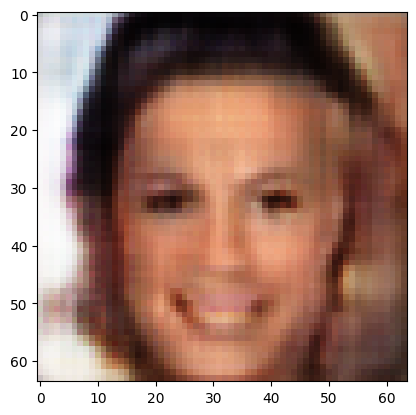

In [96]:
plt.imshow(img)

# FID Computation

In [97]:
from torcheval.metrics import FrechetInceptionDistance
fid = FrechetInceptionDistance(device = device)

idl = iter(train_loader)
for i in tqdm(range(8)):
    reals = ((next(idl))[0] * 1).to(device)
    # reals = (reals + 1) / 2
    fid.update(reals, True)

for i in tqdm(range(8)):
    fakes = generate_image(num_image=64)
    fakes = torch.clamp(fakes, 0, 1)
    fid.update(fakes, False)

100%|██████████| 8/8 [00:01<00:00,  7.32it/s]


In [98]:
fid.compute()

tensor(79.7854, device='cuda:0')